# Hill climbing art

In [1]:
import numpy as np
from PIL import Image

# open the target image
target_image_path = 'images/Jimi_Hendrix_1967_uncropped.jpg'
im_target = Image.open(target_image_path).convert('L')

In [2]:
np.asarray(im_target)

array([[153, 133, 133, ..., 187, 196, 187],
       [155, 152, 137, ..., 190, 195, 188],
       [160, 158, 155, ..., 190, 193, 173],
       ...,
       [233, 243, 244, ..., 157, 140, 120],
       [235, 237, 237, ..., 157, 112, 109],
       [233, 235, 235, ..., 143,  94,  88]], dtype=uint8)

In [3]:
print(np.asarray(im_target).shape)
print(np.asarray(im_target).T.shape == im_target.size)

(954, 1280)
True


In [4]:
im_target.size

(1280, 954)

Can draw a circle on our generated image using `ImageDraw`. 

For example here we draw a black circle on a new blank image. 

In [5]:
BLACK = 0
WHITE = 255

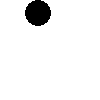

In [6]:
from PIL import ImageDraw

# new image
im = Image.new(mode='L', size=(100, 100), color=WHITE)

# draw object
draw = ImageDraw.Draw(im)
draw.ellipse(xy=((25, 0), # starting coordinate
                 (50, 25)), # ending coordinate
             fill=BLACK)

# im.save('images/circle_draw_example.jpg')
im

Difference between 2 images

### Image comparison

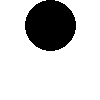

In [7]:
from PIL import ImageChops

# image with a black circle
im1 = Image.new(mode='L', size=(100, 100), color=WHITE)

draw = ImageDraw.Draw(im1)
draw.ellipse(xy=((25, 0), # starting coordinate
                 (75, 50)), # ending coordinate
             fill=BLACK)

# gray circle
im2 = Image.new(mode='L', size=(100, 100), color=WHITE)
draw = ImageDraw.Draw(im2)
draw.ellipse(xy=((50, 0), # starting coordinate
                 (100, 50)), # ending coordinate
             fill=180)
# im1.save('images/black_circle.jpg')
im1

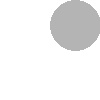

In [8]:
# im2.save('images/gray_circle.jpg')
im2

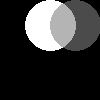

In [9]:
# ImageChops.difference(im1, im2).save('images/circle_diff.jpg')
ImageChops.difference(im1, im2)

What's the average difference of these images? 

In [10]:
im_diff = ImageChops.difference(im1, im2)
array_diff = np.asarray(im_diff)
percent_diff = array_diff.mean() / WHITE  # standardize to percent terms
print(f'im1 and im2 are {round(percent_diff * 100, 2)}% different')

im1 and im2 are 21.44% different


In [11]:
def find_img_diff_pct(im1: Image.Image, im2: Image.Image) -> float:
    assert im1.size == im2.size
    return np.asarray(ImageChops.difference(im1, im2)).mean() / WHITE

### Drawing random circles

In [12]:
CIRCLE_START_RADIUS = 100
CIRCLE_END_RADIUS = 4
CIRCLE_PERCENT_VARIANCE = 0.2

In [13]:
def choose_circle_radius(percent_complete: float) -> float:
    alpha = alpha_func(percent_complete)
    circle_radius_target = int(CIRCLE_START_RADIUS - (CIRCLE_START_RADIUS - CIRCLE_END_RADIUS) * alpha)
    # add a bit of variance to the circle radius
    circle_radius = int(random.uniform(1 - CIRCLE_PERCENT_VARIANCE,
                                           1 + CIRCLE_PERCENT_VARIANCE) * circle_radius_target)
    return circle_radius

In [14]:
def alpha_func(x: float) -> float:
    """x in range [0, 1] returns range [0, 1]"""
    assert 0 <= x <= 1
    return x  # linear: for x in [0, 1] just returns x

In [15]:
def alpha_func(x: float) -> float:
    """x in range [0, 1] returns range [0, 1]"""
    assert 0 <= x <= 1
    # return x  # linear: for x in [0, 1] just returns x
    return loglike(x)

def loglike(x: float, stretch: int = 40) -> float:
    return np.log((x * stretch) + 1) / np.log(stretch + 1)

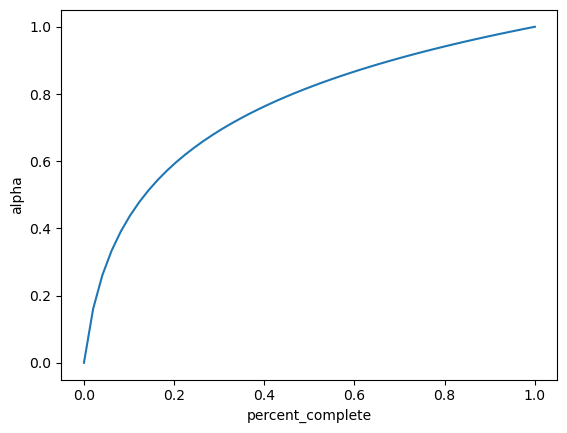

In [31]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1)
y = loglike(x)

plt.plot(x, y)
plt.xlabel('percent_complete')
plt.ylabel('alpha')
plt.savefig('images/alpha.jpg')
plt.show()

### hill climbing loop

In [33]:
import random
from time import perf_counter
import matplotlib.pyplot as plt

epoch: 0, difference: 0.3581088046460723
epoch: 10000, difference: 0.11433181238952604
epoch: 20000, difference: 0.10356591955440457
epoch: 30000, difference: 0.09611255626464421
epoch: 40000, difference: 0.09044370388354503
epoch: 50000, difference: 0.08677459715542402
epoch: 60000, difference: 0.08258129149196365
epoch: 70000, difference: 0.07976932138159247
epoch: 80000, difference: 0.0767205034529535
epoch: 90000, difference: 0.07436270656061167
epoch: 100000, difference: 0.0724386259351749
number of good guesses: 3903
good guess percent: 0.03903
Total time: 6.31 min


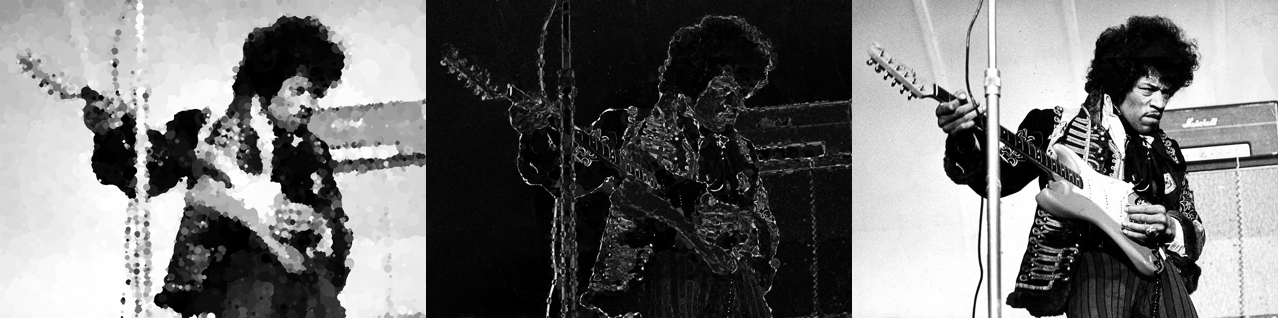

In [36]:
X_MAX = im_target.size[0]
Y_MAX = im_target.size[1]

CIRCLE_MAX_RADIUS = 100
CIRCLE_MIN_RADIUS = 4
CIRCLE_PERCENT_VARIANCE = 0.2

MAX_ITERATIONS = 100_000

# for reproducibility
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

# initial blank starting image
im_generated = Image.new(mode='L', size=im_target.size, color=WHITE)

# 1 initial difference
diff_generated_init = find_img_diff_pct(im_generated, im_target)
diff_generated = diff_generated_init
diff_compare = diff_generated

num_pixels = np.ones(im_target.size).size

# keep track of progress
diff_list = []
guess_diff_list = []
good_guess_pct_list = []

good_guesses = 0
epoch = 0

# time progress
t0 = perf_counter()

while epoch < MAX_ITERATIONS:
    # 2 draw a random circle
    # random radius
    alpha = alpha_func(epoch / MAX_ITERATIONS)  # increases from 0 to 1
    circle_radius_target = int(CIRCLE_START_RADIUS - (CIRCLE_START_RADIUS - CIRCLE_END_RADIUS) * alpha)
    # add a bit of variance to the circle radius
    circle_radius = int(random.uniform(1 - CIRCLE_PERCENT_VARIANCE,
                                           1 + CIRCLE_PERCENT_VARIANCE) * circle_radius_target)

    # random center point
    circle_center_x = random.randint(0, X_MAX)
    circle_center_y = random.randint(0, Y_MAX)
    # start/end points as (x, y)
    circle_start_point = (circle_center_x - circle_radius, circle_center_y - circle_radius)
    circle_stop_point = (circle_center_x + circle_radius, circle_center_y + circle_radius)
    
    # random color
    circle_color = random.randrange(BLACK, WHITE+1, 1)
    
    # copy current working image
    im_compare = ImageChops.duplicate(im_generated)
    # draw a random shape on it
    draw = ImageDraw.Draw(im_compare)
    draw.ellipse((circle_start_point, circle_stop_point), fill=circle_color)

    # find difference of new im_compare with target
    diff_compare = find_img_diff_pct(im_target, im_compare)
    
    # if new im_compare is more similar to target
    if diff_compare < diff_generated:
        # switch working image to the new im_compare
        im_generated = ImageChops.duplicate(im_compare)
        diff_generated = diff_compare
        good_guesses += 1
    # else just keep the working image without the random shape
    
    # print progress
    if epoch % 10_000 == 0:
    # if epoch % 2500 == 0:
        print(f'epoch: {epoch}, difference: {diff_generated}')

    epoch += 1

    diff_list.append(diff_generated)
    guess_diff_list.append(diff_compare)
    good_guess_pct_list.append(good_guesses / epoch)
    
t1 = perf_counter()

print(f'epoch: {epoch}, difference: {diff_generated}')
print(f'number of good guesses: {good_guesses}')
print(f'good guess percent: {good_guesses / epoch}')
print(f'Total time: {round((t1 - t0) / 60, 2)} min')

# combine the generated, difference, and target images for easier viewing
im_diff = ImageChops.difference(im_target, im_generated)
new_size = (int(im_target.size[0]/3), int(im_target.size[1]/3))
im_display = Image.new('L', (im_target.size[0], new_size[1]), 255)
im_display.paste(im_generated.resize(new_size), (0, 0))
im_display.paste(im_diff.resize(new_size), (new_size[0], 0))
im_display.paste(im_target.resize(new_size), (new_size[0]*2, 0))
im_display.save('images/hill_climbing_01.jpg')
im_display

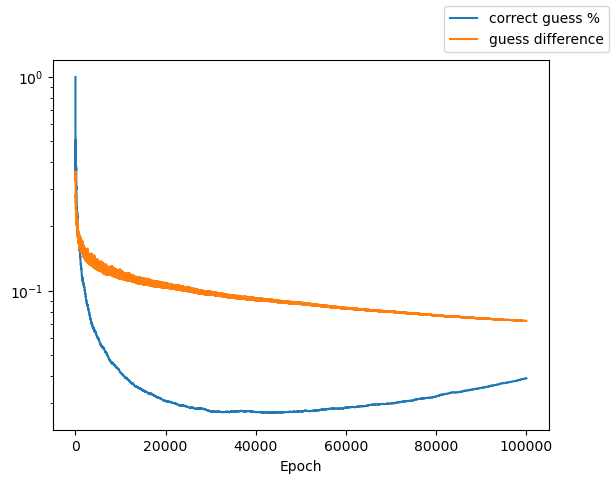

In [38]:
# plot progress stats
x = np.arange(MAX_ITERATIONS)

fig, ax = plt.subplots()

ax.plot(x, good_guess_pct_list, label='correct guess %')
ax.plot(x, guess_diff_list, label='guess difference')

ax.set_yscale('log')
ax.set_xlabel('Epoch')
fig.legend()
plt.savefig('images/hill_climbing_progress.jpg')
plt.show()